In [1]:
# % This is for my own reference: my earlier unorganized code can be found at:
# % /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/PCA_32chan_AGL/Import_mne_headmodel.ipynb
# % Created by Zhibin 4/18/2024
# % #####################################################################################################################

# % This script does the source localization (forward solution) for the 32 channel TMSI cleaned EEG data
import numpy as np
import mne
from hdf5storage import loadmat, savemat 

In [2]:
# load preprocessed cleaned EEG data of one trial from one subject in one session, such as:
ses=0 # ********************************************************* select the session
ses_num=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
ses_ID=ses_num[ses]
# load the cleaned data
outdict=loadmat('/home/zhibinz2/Documents/GitHub/Cleaned_data/clean_'+str(ses_ID)+'.mat')
dataL=outdict['dataL']
dataR=outdict['dataR']
data=[outdict['dataL'],outdict['dataR']]

subj=0 # ************************************************************ select the subject
tr=2  # ************************************************************ select the trial
preprocessed_eeg=np.transpose(data[subj][0][tr][:,0:32]*0.000001) # reduce the amplitube to be shown on MNE's plot
sampling_freq=2000

In [3]:
# info of the number of channels and the bad channels
ch_bad=[] # ch_bad=outdict['ch_bad'][0]-1
ch_dubious=[] # ch_dubious=outdict['ch_dubious'][0]-1
n_channels=np.shape(preprocessed_eeg)[0]
ch_info_bads=np.concatenate((ch_bad, ch_dubious), axis=0)
ch_info_bads=np.unique(ch_info_bads)

In [4]:
# Set the template montage for TMSi 32 channel
ch_names = [f"E{n}" for n in range(1, 33)]
ch_types = ["eeg"] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("GSN-HydroCel-32",match_case=False,match_alias=False,on_missing='raise', verbose=None)
info["description"] = 'TMSi_32'
print(info)


<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: TMSi_32
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 2000.0 Hz
>


In [5]:
# load TMSi 32 channel coordinates
outdict=loadmat('/home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/base_files/MNE/TMSI32/xyzlabels.mat') 
# (this xyzlabels.mat has coordinates from original Poly to EDF to MNE)
x=outdict['x']
y=outdict['y']
z=outdict['z']

# this set of xyz does not look right to work as digitaization points for coregistartion in 3d, but works for topoplot in 2d
for ch in range(3,len(info['dig'])):
    info['dig'][ch]['r'][0]=x[ch-3]
    info['dig'][ch]['r'][1]=y[ch-3]
    info['dig'][ch]['r'][2]=z[ch-3]

for ch in range(32):
    info['chs'][ch]['loc'][0]=x[ch]
    info['chs'][ch]['loc'][1]=y[ch]
    info['chs'][ch]['loc'][2]=z[ch]

Coordinates=np.zeros((32,3))
Coordinates[:,0]=outdict['x']
Coordinates[:,1]=outdict['y']
Coordinates[:,2]=outdict['z']

In [6]:
# mark the bad channels in the info object
ch_labels_info_bads=list()
for k in range(len(ch_info_bads)):
    ch_labels_info_bads.append(ch_names[ch_info_bads[k]])

info['bads'] = ch_labels_info_bads

In [7]:
raw = mne.io.RawArray(preprocessed_eeg, info)

Creating RawArray with float64 data, n_channels=32, n_times=251875
    Range : 0 ... 251874 =      0.000 ...   125.937 secs
Ready.


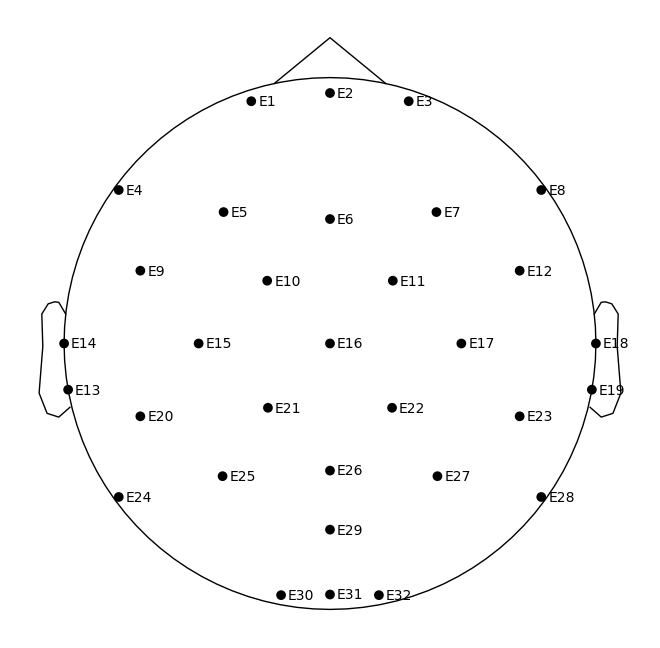

In [8]:
# visualize the sensor locations
fig = raw.plot_sensors(show_names=True)

forward solution

In [9]:
# The paths to Freesurfer reconstructions
subjects_dir ='../base_files/MNE/subjects'
subject = 'fsaverage' # change it to use freesurfer's bem
# Such brain model for fsaverage or MNI can be found in Freesurfer or MNE's installation directery
# freesurfer/freesurfer/subjects
# mne_data/MNE-sample-data/subjects

# Compute Source Space (surface)
ico = 4 #**************************************************************
spacing='ico'+str(ico) 
src = mne.setup_source_space(subject, spacing=spacing, add_dist='patch',
                             subjects_dir=subjects_dir)
conductivity = (0.3, 0.0075, 0.3)  #  three layers for EEG (MNE default  (0.3 0.006 0.3) )
model = mne.make_bem_model(subject=subject, ico=ico,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)

bem = mne.make_bem_solution(model)
# This take about 1 minute

# load transforamtion file for TMSi 32 channel
trans = '/home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/base_files/MNE/TMSI32/tmsi_trans.fif'
# This tranformation file is created by GUI operation using "mne.gui.coregistration()"
# For other EEG system, refer to:
# https://mne.tools/stable/auto_tutorials/forward/20_source_alignment.html#sphx-glr-auto-tutorials-forward-20-source-alignment-py
# https://mne.tools/stable/generated/mne.gui.coregistration.html 
# for the construction of this transformation file

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/TMSI_32chan/../base_files/MNE/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/TMSI_32chan/../base_files/MNE/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/TMSI_32chan/../base_files/MNE/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/TMSI_32chan/../base_files/MNE/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (4) ...
    Triangle neighbors and ver

In [10]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=True)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562>, <surface (rh), n_vertices=163842, n_used=2562>] MRI (surface RAS) coords, subject 'fsaverage', ~30.8 MB>
MRI -> head transform : /home/zhibinz2/Documents/GitHub/EEG_pipeline/HNL/ZHIBIN/base_files/MNE/TMSI32/tmsi_trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999231 -0.035340  0.017012      -2.10 mm
     0.036517  0.996533 -0.074755      12.96 mm
    -0.014311  0.075319  0.997057      -2.61 mm
     0.000000  0.000000  0.000000       1.00



Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 2562 points...
    Found  609/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/1953 points outside using surface Qhull


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/1953 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 6378.3 ms
Checking surface interior status for 2562 points...
    Found  561/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/2001 points outside using surface Qhull


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/2001 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 495.2 ms

Setting up for EEG...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished


Computing EEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Finished.
<Forward | MEG channels: 0 | EEG channels: 32 | Source space: Surface with 5124 vertices | Source orientation: Free>


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s finished


In [11]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
source_rr=fwd_fixed['source_rr']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 32 sensors x 5124 dipoles


In [ ]:
# save outputs all in one mat file. 
outdict=dict()
outdict['leadfield']=leadfield # leadfield matrix
# savemat('../base_files/MNE/TMSI32/leadfield.mat',outdict)
outdict=dict()
outdict['source_rr']=source_rr # the source location AND labels (matlab)
# savemat('../base_files/MNE/TMSI32/source_rr.mat',outdict)

Using surface: ../base_files/MNE/subjects/fsaverage/bem/inner_skull.surf
Using surface: ../base_files/MNE/subjects/fsaverage/bem/outer_skull.surf
Using surface: ../base_files/MNE/subjects/fsaverage/bem/outer_skin.surf


/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


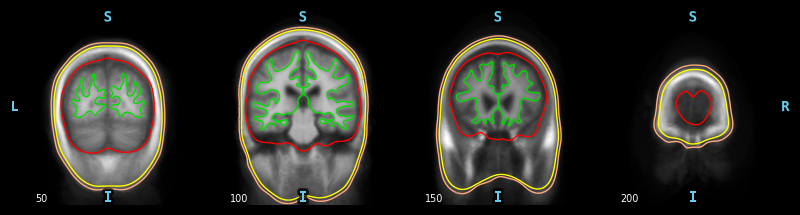

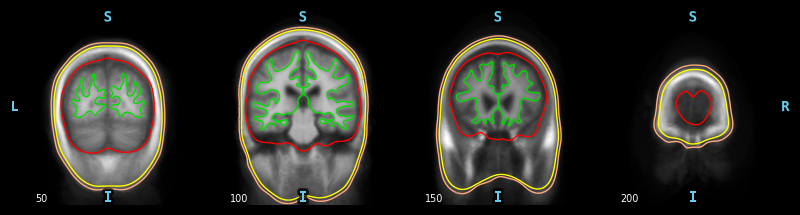

In [49]:
# view surfaces
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

In [12]:
fig = mne.viz.plot_alignment(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="white",
    coord_frame="mri",
    src=src,
)
mne.viz.set_3d_view(
    fig,
    azimuth=173.78,
    elevation=101.75,
    distance=0.30,
    focalpoint=(-0.03, -0.01, 0.03),
)

Using pyvistaqt 3d backend.

